In [1]:
# Improve by ChatGPT & GitHub Copilot
# Running the requierements.ipynb
%run /bettik/PROJECTS/pr-data-ocean/riverama/Notebooks/requierements.ipynb

## Filter

In [2]:
def transform_to_regular_grid(ssh_hf_1h_masked):
    # Set up UTM Zone 58S projection
    proj = Proj(proj='utm', zone=58, south=True, ellps='WGS84')

    # Get latitude and longitude data
    lat = ssh_hf_1h_masked.lat.values
    lon = ssh_hf_1h_masked.lon.values

    # Transform lat, lon to UTM coordinates
    x, y = np.vectorize(proj)(lon, lat)

    # Convert coordinates from meters to kilometers
    x_km = x / 1000
    y_km = y / 1000

    x_min, x_max = x_km.min(), x_km.max()
    y_min, y_max = y_km.min(), y_km.max()

    # Define new grid
    x_new = np.arange(x_min, x_max, dx)
    y_new = np.arange(y_min, y_max, dy)
    x_grid, y_grid = np.meshgrid(x_new, y_new)

    # Interpolate to the new grid using 'nearest' for robust handling of NaNs
    data_interp = griddata(
        (x_km.flatten(), y_km.flatten()),
        ssh_hf_1h_masked.values.flatten(),
        (x_grid, y_grid),
        method='nearest'
    )

    # Create new DataArray with the interpolated data on the regular grid
    ssh_hf_1h_masked_regular = xr.DataArray(data_interp, coords=[('y', y_new), ('x', x_new)], dims=['y', 'x'])
    
    return ssh_hf_1h_masked_regular


In [3]:
def fill_nan(ssh_hf_1h_masked_regular):
    # Define the axes correctly using pyinterp.core.Axis
    x_axis = pyinterp.core.Axis(ssh_hf_1h_masked_regular.x.values, is_circle=True)
    y_axis = pyinterp.core.Axis(ssh_hf_1h_masked_regular.y.values, is_circle=True)
    
    # Prepare the grid using pyinterp.Grid2D
    grid = pyinterp.Grid2D(y_axis, x_axis, ssh_hf_1h_masked_regular.values)

    # Apply Gauss-Seidel method to fill data
    has_converged, ssh_hf_1h_masked_regular_filled = fill.gauss_seidel(grid, num_threads=16)
    
    return has_converged, ssh_hf_1h_masked_regular_filled

In [4]:
def extend(ssh,nx,ny):
    ssh_extended = np.empty((3*ny,3*nx))
    ssh_extended[ny:2*ny,nx:2*nx] = +ssh
    ssh_extended[0:ny,nx:2*nx] = +ssh[::-1,:]
    ssh_extended[2*ny:3*ny,nx:2*nx] = +ssh[::-1,:]
    ssh_extended[:,0:nx] = ssh_extended[:,nx:2*nx][:,::-1]
    ssh_extended[:,2*nx:3*nx] = ssh_extended[:,nx:2*nx][:,::-1]
    return ssh_extended

In [5]:
def lowpass(_lambda,nx,ny,wavenum2D) : 
    _lowpass = np.zeros((3*ny,3*nx))
    for i in range (3*ny):
        for j in range(3*nx):
            if wavenum2D[i,j]<1/_lambda:
                _lowpass[i,j] = 1
    return _lowpass 

In [6]:
def gaspari_cohn(array,distance,center):
    if type(array) is float or type(array) is int:
        array = np.array([array])
    else:
        array = array
    if distance<=0:
        return np.zeros_like(array)
    else:
        array = 2*np.abs(array-center*np.ones_like(array))/distance
        gp = np.zeros_like(array)
        i= np.where(array<=1.)[0]
        gp[i]=-0.25*array[i]**5+0.5*array[i]**4+0.625*array[i]**3-5./3.*array[i]**2+1.
        i =np.where((array>1.)*(array<=2.))[0]
        gp[i] = 1./12.*array[i]**5-0.5*array[i]**4+0.625*array[i]**3+5./3.*array[i]**2-5.*array[i]+4.-2./3./array[i]
        #if type(r) is float:
        #    gp = gp[0]
    return gp

In [7]:
def create_spatial_window(nx,ny):
    result = np.ones((3*ny,3*nx))
    
    gaspari_x = np.expand_dims(gaspari_cohn(np.arange(2*nx),nx,nx),axis=0)
    gaspari_y = np.expand_dims(gaspari_cohn(np.arange(2*ny),ny,ny),axis=1)

    #paving edges with gaspari-cohn
    result[2*ny:,nx:2*nx] = np.repeat(gaspari_y[ny:,:],repeats=nx,axis=1)
    result[:ny,nx:2*nx] = np.repeat(gaspari_y[:ny,:],repeats=nx,axis=1)
    result[ny:2*ny,0:nx] = np.repeat(gaspari_x[:,:nx],repeats=ny,axis=0)
    result[ny:2*ny,2*nx:] = np.repeat(gaspari_x[:,nx:],repeats=ny,axis=0)

    #paving corners with gaspari-cohn
    result[2*ny:,2*nx:]=gaspari_y[ny:,:]*gaspari_x[:,nx:]
    result[:ny,:nx]=gaspari_y[:ny,:]*gaspari_x[:,:nx]
    result[2*ny:,:nx]=gaspari_y[ny:,:]*gaspari_x[:,:nx]
    result[:ny,2*nx:]=gaspari_y[:ny,:]*gaspari_x[:,nx:]

    return result 

In [8]:
def bar_igw_filter(date_str, lambda_bar=100):
    # Parse the date string to get the month
    date = pd.to_datetime(date_str)
    month = date.month

    # Construct the file path using the extracted month
    file_path = f"/bettik/PROJECTS/pr-data-ocean/riverama/Datos/Filtrage/ssh_hf/ssh_hf_{month:02}.nc"
    ssh_hf = xr.open_mfdataset(file_path)
    
    # Date selection
    ssh_hf_1h = ssh_hf.rename({'__xarray_dataarray_variable__': 'ssh_hf'}).sel(time_counter=date).load()
    
    # Applying mask
    mask = xr.open_dataset('/bettik/PROJECTS/pr-data-ocean/riverama/Datos/CALEDO60/1_mesh_mask_TROPICO12_L125_tr21.nc', drop_variables={"x", "y"}) 
    ssh_hf_1h_masked = ssh_hf_1h['ssh_hf'].where(mask.tmaskutil[0,:,:] == 1, np.nan).load()

    # Transform and fill missing data
    ssh_hf_1h_masked_regular = transform_to_regular_grid(ssh_hf_1h_masked)
    ssh_hf_1h_masked_regular_filled = fill_nan(ssh_hf_1h_masked_regular)[1]
    
    # Extend the filled data
    nx = int(ssh_hf_1h_masked_regular_filled.shape[1])
    ny = int(ssh_hf_1h_masked_regular_filled.shape[0])
    ssh_hf_1h_masked_regular_filled_extended = extend(ssh_hf_1h_masked_regular_filled, nx, ny)
    
    # Frequency domain processing
    kx = np.fft.fftfreq(3*nx, dx)  # in km
    ky = np.fft.fftfreq(3*ny, dy)  # in km
    k, l = np.meshgrid(kx, ky)
    wavenum2D = np.sqrt(k**2 + l**2)
    
    # Apply window function
    window = create_spatial_window(nx, ny)
    ssh_hf_1h_masked_regular_filled_extended_windowed = ssh_hf_1h_masked_regular_filled_extended * window
    
    # Filter in the frequency domain
    lowpass_bar = lowpass(lambda_bar, nx, ny, wavenum2D)
    ssh_hf_freq = fp.fft2(ssh_hf_1h_masked_regular_filled_extended_windowed)
    ssh_freq_filtered = lowpass_bar * ssh_hf_freq
    ssh_bar = np.real(fp.ifft2(ssh_freq_filtered))[ny:2*ny, nx:2*nx]
    
    # Calculate the internal gravity waves (IGW)
    ssh_igw = ssh_hf_1h_masked_regular_filled - ssh_bar
    
    return ssh_igw, ssh_bar

## Plotting

### Only 1 $\lambda$

In [ ]:
date_to_process = '2014-12-29T03:30:00' # disponible a partir del 2014-01-03T14:30:00 hasta 2014-12-29T03:30:00
lambda_value = 300  # km
dx=1.7 #km for the grid
dy=1.7 #km
ssh_igw, ssh_bar = bar_igw_filter(date_to_process, lambda_bar=lambda_value)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
date_readable = pd.to_datetime(date_to_process).strftime('%Y-%m-%d %H:%M')

im1 = axes[0].pcolormesh(np.abs(ssh_bar), cmap=cmocean.cm.curl
                         ,vmin=-0.6, vmax=0.6
                         )
fig.colorbar(im1, ax=axes[0])
axes[0].set_title('$\eta^{BAR}$')
im2 = axes[1].pcolormesh(ssh_igw, cmap=cmocean.cm.curl)
fig.colorbar(im2, ax=axes[1])
axes[1].set_title('$\eta^{IGW}$')

title = f"$\\lambda = {lambda_value}$ km [{date_readable}]"
fig.suptitle(title)
fig.subplots_adjust(top=0.85)

# # Save the figure to a specific directory
# save_path = "/bettik/PROJECTS/pr-data-ocean/riverama/Frames/BAR_IGW"
# fig.savefig(f"{save_path}/bar_igw_plot.png")  # Adjust filename as needed

# Display the plot
plt.show()


### 9 $\lambda$ comparison

In [ ]:
# Assuming bar_igw_filter is defined elsewhere and correctly set up
date_to_process = '2014-12-29T03:30:00'
lambda_values = [50, 100, 250, 350, 400, 450, 550, 700, 900]  # Different lambda values to compare
dx=1.7 #km for the grid
dy=1.7 #km
# Set up the overall figure and GridSpec layout
fig = plt.figure(figsize=(24, 12))
gs = gridspec.GridSpec(6, 6, height_ratios=[0.01, 3, 0.01, 3, 0.01, 3])  # Allocating rows for titles and plots

# Loop through each lambda value and plot in matrix form
for i, lambda_value in enumerate(lambda_values):
    row = (i // 3) * 2  # Determine the row of the grid (times 2 to account for title rows)
    col = (i % 3) * 2  # Determine the column (times 2 for side-by-side plots)

    # Create subplots for BAR and IGW
    bar_ax = fig.add_subplot(gs[row+1, col])
    igw_ax = fig.add_subplot(gs[row+1, col+1])

    # Process the data
    ssh_igw, ssh_bar = bar_igw_filter(date_to_process, lambda_bar=lambda_value)

    # Barotropic component
    im1 = bar_ax.pcolormesh(np.abs(ssh_bar), cmap=cmocean.cm.curl, vmin=-0.6, vmax=0.6)
    bar_ax.set_aspect('equal', adjustable='box')  # Set axes as equal
    fig.colorbar(im1, ax=bar_ax, shrink=0.65)
    bar_ax.set_title(f'$\eta^{{BAR}}$ with $\lambda={lambda_value}$ km', fontsize=10)


    # Inertia-gravity waves component
    im2 = igw_ax.pcolormesh(ssh_igw, cmap=cmocean.cm.curl, vmin=-0.2, vmax=0.2)
    igw_ax.set_aspect('equal', adjustable='box')  # Set axes as equal
    fig.colorbar(im2, ax=igw_ax, shrink=0.65)
    igw_ax.set_title(f'$\eta^{{IGW}}$ with $\lambda={lambda_value}$ km', fontsize=10)

# Add a general title for the entire figure
date_readable = pd.to_datetime(date_to_process).strftime('%Y-%m-%d %H:%M')
fig.suptitle(date_readable, fontsize=14)
fig.subplots_adjust(top=0.5, hspace=0.1, wspace=0.8)  # Adjust spacing between subplots
plt.tight_layout()
plt.show()


## Animation

### Only 1 $\lambda$

In [ ]:
lambda_value = 500  # km
dx=1.7 #km for the grid
dy=1.7 #km

# Time range for processing
start_date = '2014-01-09T00:30:00'
end_date = '2014-01-11T23:30:00'
time_range = pd.date_range(start=start_date, end=end_date, freq='H')  # Daily frequency, adjust as needed

# Path for saving the images
save_path = "/bettik/PROJECTS/pr-data-ocean/riverama/Frames/BAR_IGW/lambda_500"
frame_counter = 192  # Start the frame counter from this number

for date_to_process in time_range:
    ssh_igw, ssh_bar = bar_igw_filter(date_to_process, lambda_bar=lambda_value)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    date_readable = pd.to_datetime(date_to_process).strftime('%Y-%m-%d %H:%M')

    im1 = axes[0].pcolormesh(np.abs(ssh_bar), cmap=cmocean.cm.curl, vmin=-0.6, vmax=0.6)
    fig.colorbar(im1, ax=axes[0])
    axes[0].set_title('$\eta^{BAR}$')

    im2 = axes[1].pcolormesh(ssh_igw, cmap=cmocean.cm.curl)
    fig.colorbar(im2, ax=axes[1])
    axes[1].set_title('$\eta^{IGW}$')

    title = f"$\\lambda = {lambda_value}$ km [{date_readable}]"
    fig.suptitle(title)
    fig.subplots_adjust(top=0.85)

    filename = f"{save_path}/frame_{frame_counter:04d}.png"
    fig.savefig(filename)  # Save the figure
    plt.close(fig)  # Close the plot to free up memory

    frame_counter += 1  # Increment the frame counter

print("ta da!")


### 9 $\lambda$ 's comparison

In [ ]:
dx=1.7 #km for the grid
dy=1.7 #km

# Time range for processing
start_date = '2014-01-09T21:30:00'
#end_date = '2014-01-09T00:30:00' for testing
end_date = '2014-01-11T23:30:00'
time_range = pd.date_range(start=start_date, end=end_date, freq='H')

# Different lambda values to compare
lambda_values = [50, 100, 250, 350, 400, 450, 550, 700, 1000]

# Path for saving the images
save_path = "/bettik/PROJECTS/pr-data-ocean/riverama/Frames/BAR_IGW/combined_lambdas"
frame_counter = 213  # Start the frame counter from this number

# Loop through each date in the time range
for date_to_process in time_range:
    # Set up the overall figure and GridSpec layout
    fig = plt.figure(figsize=(24, 12))
    gs = gridspec.GridSpec(6, 6, height_ratios=[0.01, 3, 0.01, 3, 0.01, 3])

    # Loop through each lambda value and plot in matrix form
    for i, lambda_value in enumerate(lambda_values):
        row = (i // 3) * 2  # Determine the row of the grid (times 2 to account for title rows)
        col = (i % 3) * 2  # Determine the column (times 2 for side-by-side plots)

        # Create subplots for BAR and IGW
        bar_ax = fig.add_subplot(gs[row+1, col])
        igw_ax = fig.add_subplot(gs[row+1, col+1])

        # Process the data for current date and lambda
        ssh_igw, ssh_bar = bar_igw_filter(date_to_process, lambda_bar=lambda_value)

        # Barotropic component
        im1 = bar_ax.pcolormesh(np.abs(ssh_bar), cmap=cmocean.cm.curl, vmin=-0.6, vmax=0.6)
        bar_ax.set_aspect('equal', adjustable='box')  # Set axes as equal
        fig.colorbar(im1, ax=bar_ax, shrink=0.65)
        bar_ax.set_title(f'$\eta^{{BAR}}$ with $\lambda={lambda_value}$ km', fontsize=10)

        # Inertia-gravity waves component
        im2 = igw_ax.pcolormesh(ssh_igw, cmap=cmocean.cm.curl, vmin=-0.15, vmax=0.15)
        igw_ax.set_aspect('equal', adjustable='box')  # Set axes as equal
        fig.colorbar(im2, ax=igw_ax, shrink=0.65)
        igw_ax.set_title(f'$\eta^{{IGW}}$ with $\lambda={lambda_value}$ km', fontsize=10)

    # Add a general title for the entire figure
    date_readable = pd.to_datetime(date_to_process).strftime('%Y-%m-%d %H:%M')
    fig.suptitle(date_readable, fontsize=14)
    fig.subplots_adjust(top=1, hspace=0.2, wspace=0.4)  # Adjust spacing between subplots

    # Saving the figure
    filename = f"{save_path}/frame_{frame_counter:04d}.png"
    fig.savefig(filename)  # Save the figure
    plt.close(fig)  # Close the plot to free up memory

    frame_counter += 1  # Increment the frame counter
    
print("ta da!")


## Regridding

In [9]:
# Loading ssh_hf and making and selecting 1h for testing
ssh_hf = xr.open_mfdataset("/bettik/PROJECTS/pr-data-ocean/riverama/Datos/Filtrage/ssh_hf/ssh_hf_01.nc")
ssh_hf_1h = ssh_hf.rename({'__xarray_dataarray_variable__': 'ssh_hf'}).sel(time_counter=pd.to_datetime('2014-01-10T00:30:00')).load()

# Appying the mask to ssh_hf_1h, keep data where mask is equal to 1
mask = xr.open_dataset('/bettik/PROJECTS/pr-data-ocean/riverama/Datos/CALEDO60/1_mesh_mask_TROPICO12_L125_tr21.nc',drop_variables={"x","y"}) 
ssh_hf_1h_masked = ssh_hf_1h['ssh_hf'].where(mask.tmaskutil[0,:,:] == 1, np.nan).load()

In [10]:
dx = 1.7
dy = 1.7
date_to_process = '2014-01-10T00:30:00'
lambda_value = 400  # km
ssh_igw, ssh_bar = bar_igw_filter(date_to_process, lambda_bar=lambda_value)

In [11]:
ssh_igw

array([[ 0.00742377,  0.00749433,  0.00761171, ..., -0.00383626,
        -0.00385892, -0.0038638 ],
       [ 0.00759173,  0.00769079,  0.00779052, ..., -0.00384784,
        -0.00386265, -0.00386143],
       [ 0.0077619 ,  0.00786721,  0.00796416, ..., -0.00389196,
        -0.00388039, -0.00389588],
       ...,
       [-0.03024754, -0.03020183, -0.03009131, ...,  0.03069533,
         0.0307697 ,  0.03069072],
       [-0.03016787, -0.03012867, -0.02999088, ...,  0.03046606,
         0.03053464,  0.03044067],
       [-0.03018192, -0.03014175, -0.03000128, ...,  0.03037213,
         0.03042648,  0.03033666]])

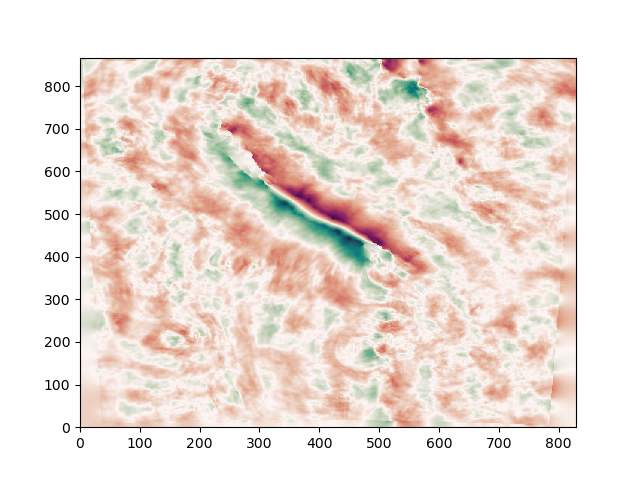

In [12]:
plt.figure()
plt.pcolormesh(ssh_igw, cmap=cmocean.cm.curl)
plt.show()

In [13]:
ssh_hf_1h_masked_regular = transform_to_regular_grid(ssh_hf_1h_masked)

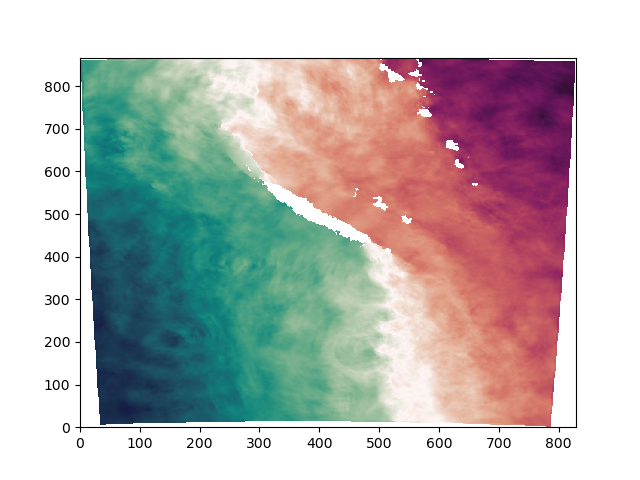

In [25]:
plt.figure()
plt.pcolormesh(ssh_hf_1h_masked_regular, cmap=cmocean.cm.curl)
plt.show()

In [15]:
ssh_hf_1h_masked_regular

<xarray.DataArray (y: 867, x: 829)> Size: 6MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * y        (y) float64 7kB 6.791e+03 6.793e+03 ... 8.262e+03 8.264e+03
  * x        (x) float64 7kB -118.8 -117.1 -115.4 ... 1.287e+03 1.289e+03

In [16]:
# Define the coordinate ranges and steps as specified
y_values = np.linspace(6791.458971, 8263.658971, 867)  # Corresponds to your 'y' dimension size and range
x_values = np.linspace(-118.79531027908135, 1288.804689720921, 829)  # Corresponds to your 'x' dimension size and range

# Create the DataArray
ssh_igw_da = xr.DataArray(
    data=ssh_igw,
    dims=["y", "x"],
    coords={
        "y": y_values,
        "x": x_values
    }
)

# Optionally, you can specify attributes or additional coordinates if needed
ssh_igw_da.attrs['description'] = 'SSH IGW component'

In [17]:
ssh_igw_da

<xarray.DataArray (y: 867, x: 829)> Size: 6MB
array([[ 0.00742377,  0.00749433,  0.00761171, ..., -0.00383626,
        -0.00385892, -0.0038638 ],
       [ 0.00759173,  0.00769079,  0.00779052, ..., -0.00384784,
        -0.00386265, -0.00386143],
       [ 0.0077619 ,  0.00786721,  0.00796416, ..., -0.00389196,
        -0.00388039, -0.00389588],
       ...,
       [-0.03024754, -0.03020183, -0.03009131, ...,  0.03069533,
         0.0307697 ,  0.03069072],
       [-0.03016787, -0.03012867, -0.02999088, ...,  0.03046606,
         0.03053464,  0.03044067],
       [-0.03018192, -0.03014175, -0.03000128, ...,  0.03037213,
         0.03042648,  0.03033666]])
Coordinates:
  * y        (y) float64 7kB 6.791e+03 6.793e+03 ... 8.262e+03 8.264e+03
  * x        (x) float64 7kB -118.8 -117.1 -115.4 ... 1.287e+03 1.289e+03
Attributes:
    description:  SSH IGW component

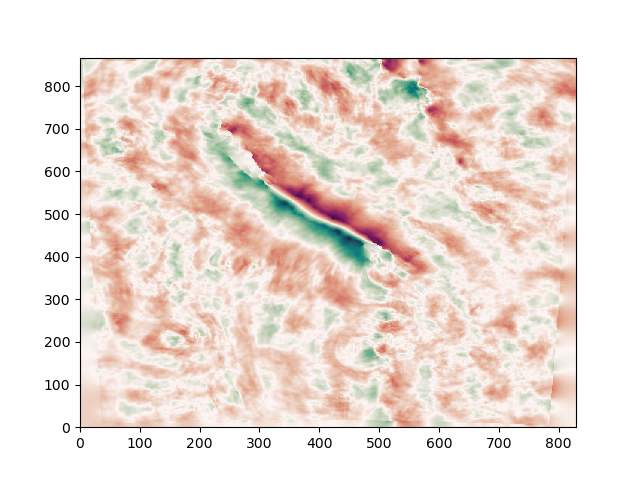

In [18]:
plt.figure()
plt.pcolormesh(ssh_igw_da, cmap=cmocean.cm.curl)
plt.show()

In [19]:
def transform_to_geographic(data_array, zone, is_south=True):
    """Convert projected coordinates (assumed to be UTM) back to geographic (longitude, latitude)."""
    # Define the projection for UTM and geographic
    proj_utm = Proj(proj='utm', zone=zone, south=is_south, ellps='WGS84')
    transformer = Transformer.from_proj(proj_utm, Proj(proj='latlong', datum='WGS84'), always_xy=True)
    
    # Get the projected coordinates from the DataArray
    x_proj, y_proj = np.meshgrid(data_array.x.values, data_array.y.values)
    
    # Flatten the arrays for transformation
    x_flat, y_flat = x_proj.flatten(), y_proj.flatten()
    
    # Convert the projected coordinates back to geographic coordinates
    lon, lat = transformer.transform(x_flat, y_flat)
    
    # Reshape the results back to the original dimensions
    lon = lon.reshape(x_proj.shape)
    lat = lat.reshape(y_proj.shape)
    
    # Create a new DataArray with the same data but with new geographic coordinates
    return xr.DataArray(
        data_array.data,
        coords={
            'lon': (('y', 'x'), lon),
            'lat': (('y', 'x'), lat)
        },
        dims=['y', 'x']
    )

# Apply the function to your DataArray, assuming 'ssh_igw_da' is the array and zone 58
geo_data = transform_to_geographic(ssh_igw_da, 58)


In [20]:
ssh_hf_1h_masked

<xarray.DataArray 'ssh_hf' (y: 853, x: 788)> Size: 5MB
array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan, -0.46211706, -0.46209282, ...,  0.12072774,
         0.12077472,         nan],
       [        nan, -0.46215664, -0.4621357 , ...,  0.12070754,
         0.12075365,         nan],
       ...,
       [        nan, -0.28550266, -0.28544754, ...,  0.33252342,
         0.33249071,         nan],
       [        nan, -0.28555795, -0.28550192, ...,  0.33252699,
         0.33249866,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]])
Coordinates:
    lat      (y, x) float32 3MB -28.8 -28.8 -28.8 -28.8 ... -15.7 -15.7 -15.7
    lon      (y, x) float32 3MB 159.2 159.2 159.3 159.3 ... 172.3 172.3 172.3
Dimensions without coordinates: y, x

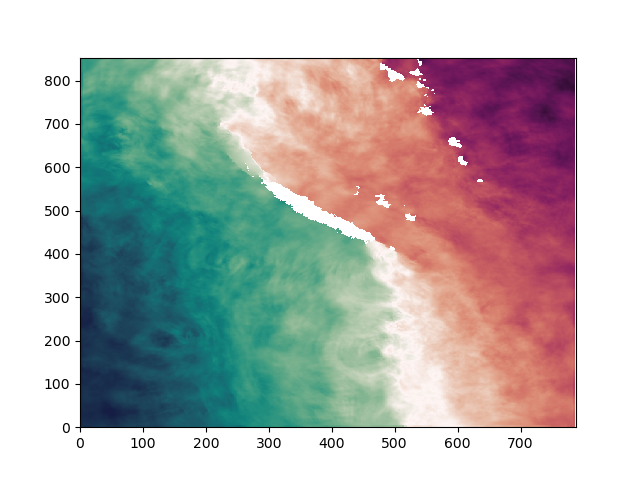

In [21]:
plt.figure()
plt.pcolormesh(ssh_hf_1h_masked, cmap=cmocean.cm.curl)
plt.show()

In [24]:
import xarray as xr
import numpy as np
from pyproj import Proj, Transformer

def transform_to_geographic(data_array, zone, is_south=True):
    proj_utm = Proj(proj='utm', zone=zone, south=is_south, ellps='WGS84')
    transformer = Transformer.from_proj(proj_utm, Proj(proj='latlong', datum='WGS84'), always_xy=True)
    
    x_proj, y_proj = np.meshgrid(data_array.x.values, data_array.y.values)
    x_flat, y_flat = x_proj.flatten(), y_proj.flatten()
    lon, lat = transformer.transform(x_flat, y_flat)
    lon = lon.reshape(x_proj.shape)
    lat = lat.reshape(y_proj.shape)
    
    return xr.DataArray(
        data_array.data,
        coords={'lon': (('y', 'x'), lon), 'lat': (('y', 'x'), lat)},
        dims=['y', 'x']
    )

# Assuming 'ssh_igw_da' is the input DataArray
geo_data = transform_to_geographic(ssh_igw_da, 58)

# Adjust geo_data if 'lon' and 'lat' are not dimensions
if 'lon' not in geo_data.dims or 'lat' not in geo_data.dims:
    geo_data = geo_data.set_index({'y': 'lat', 'x': 'lon'})

# Perform interpolation if dimensions are correctly set in ssh_hf_1h_masked
if 'lon' in ssh_hf_1h_masked.coords and 'lat' in ssh_hf_1h_masked.coords:
    interpolated_geo_data = geo_data.interp(
        lon=ssh_hf_1h_masked.lon,  # 2D coordinates from ssh_hf_1h_masked
        lat=ssh_hf_1h_masked.lat,  # 2D coordinates from ssh_hf_1h_masked
        method='linear'
    )
    interpolated_geo_data = interpolated_geo_data.where(~ssh_hf_1h_masked.isnull())
else:
    print("Missing 'lon' or 'lat' coordinates in ssh_hf_1h_masked.")


ValueError: dimension mismatch: try setting an index for dimension 'y' with variable 'lat' that has dimensions ('y', 'x')